In [1]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
import torch.nn as nn
import numpy as np

In [2]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GSoC2021/Data/Dataset.csv")
dataset

,Experiment,Particle,E1,pt1,eta1,phi1
0,2,j,1069460.0,751597.0,0.858186,-1.842170
1,3,j,676000.0,640429.0,0.330450,0.704554
2,4,j,936707.0,616229.0,0.973383,-1.565920
3,5,j,640313.0,589524.0,0.390749,1.237340
4,6,j,583373.0,545730.0,0.364057,-1.607320
...,...,...,...,...,...,...
22656,4003,j,58571.5,31726.6,1.209330,-1.832740
22657,4484,j,124037.0,36075.6,-1.901150,1.240720
22658,4998,j,271819.0,24791.0,3.085510,0.893034
22659,4484,j,187700.0,29610.3,2.532910,-2.436230


In [3]:
normalized_data = preprocessing.normalize([dataset.E1, dataset.pt1, dataset.eta1, dataset.phi1])

In [4]:
dataset["E1_Norm"] = normalized_data[0]
dataset["pt1_Norm"] = normalized_data[1]
dataset["eta1_Norm"] = normalized_data[2]
dataset["phi1_Norm"] = normalized_data[3]

In [5]:
dataset

,Experiment,Particle,E1,pt1,eta1,phi1,E1_Norm,pt1_Norm,eta1_Norm,phi1_Norm
0,2,j,1069460.0,751597.0,0.858186,-1.842170,0.011660,0.013896,0.003785,-0.006760
1,3,j,676000.0,640429.0,0.330450,0.704554,0.007370,0.011840,0.001457,0.002585
2,4,j,936707.0,616229.0,0.973383,-1.565920,0.010213,0.011393,0.004293,-0.005746
3,5,j,640313.0,589524.0,0.390749,1.237340,0.006981,0.010899,0.001723,0.004540
4,6,j,583373.0,545730.0,0.364057,-1.607320,0.006360,0.010089,0.001606,-0.005898
...,...,...,...,...,...,...,...,...,...,...
22656,4003,j,58571.5,31726.6,1.209330,-1.832740,0.000639,0.000587,0.005334,-0.006725
22657,4484,j,124037.0,36075.6,-1.901150,1.240720,0.001352,0.000667,-0.008385,0.004553
22658,4998,j,271819.0,24791.0,3.085510,0.893034,0.002964,0.000458,0.013609,0.003277
22659,4484,j,187700.0,29610.3,2.532910,-2.436230,0.002046,0.000547,0.011172,-0.008940


## Model

In [6]:
# Dataset
dataset_comp = [dataset.E1_Norm, dataset.pt1_Norm, dataset.eta1_Norm, dataset.phi1_Norm]
dataset_comp = np.array(dataset_comp)
dataset_comp = dataset_comp.transpose()


#

test_abs = int(len(dataset_comp) * 0.8)
data_train, data_test = random_split(dataset_comp, [test_abs, len(dataset_comp) - test_abs])

bs = 256

train_ds = TensorDataset(torch.tensor(data_train, dtype=torch.float, device="cuda"), torch.tensor(data_train, dtype=torch.float, device="cuda"))
valid_ds = TensorDataset(torch.tensor(data_test, dtype=torch.float, device="cuda"), torch.tensor(data_test, dtype=torch.float, device="cuda"))

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [7]:
class AE_3D_200_LeakyReLU(torch.nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

model = AE_3D_200_LeakyReLU()
model.to('cuda')


AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [8]:
training_loss = []
validation_loss = []

In [9]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)


for e in range(100):
    
    for t in range(100):
        # Forward pass: Compute predicted y by passing x to the model
        train_features, train_labels = next(iter(train_dl))
        valid_features, valid_labels = next(iter(valid_dl))

        y_pred = model(train_features)
        valid_pred = model(valid_features)
        # Compute and print loss
        loss = criterion(y_pred, train_labels)
        valid_loss = criterion(valid_pred, valid_labels)

        training_loss.append(loss.item())
        validation_loss.append(valid_loss.item())

        if t % 4 == 0:
            print(f"Epoch {e}: {t} -> Training Loss {loss.item()} Validation Loss {valid_loss.item()}")

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch 0: 0 -> Training Loss 0.008396790362894535 Validation Loss 0.008486373350024223
Epoch 0: 4 -> Training Loss 0.00843090284615755 Validation Loss 0.008474167436361313
Epoch 0: 8 -> Training Loss 0.008425788022577763 Validation Loss 0.008461973629891872
Epoch 0: 12 -> Training Loss 0.008435152471065521 Validation Loss 0.008449788205325603
Epoch 0: 16 -> Training Loss 0.008356526494026184 Validation Loss 0.008437613025307655
Epoch 0: 20 -> Training Loss 0.008361268788576126 Validation Loss 0.008425445295870304
Epoch 0: 24 -> Training Loss 0.008413458243012428 Validation Loss 0.008413288742303848
Epoch 0: 28 -> Training Loss 0.008322849869728088 Validation Loss 0.008401142433285713
Epoch 0: 32 -> Training Loss 0.008336488157510757 Validation Loss 0.008389008231461048
Epoch 0: 36 -> Training Loss 0.008363083004951477 Validation Loss 0.00837688334286213
Epoch 0: 40 -> Training Loss 0.008327275514602661 Validation Loss 0.00836477056145668
Epoch 0: 44 -> Training Loss 0.008300447836518288

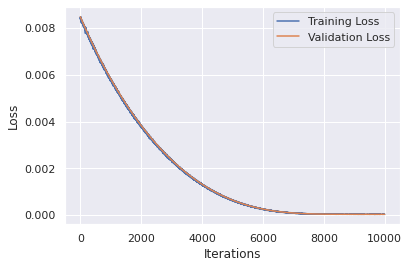

In [10]:
# Graph 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

plt.plot(range(10000),training_loss , label='Training Loss')
plt.plot(range(10000), validation_loss, label = 'Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Loss_Graph", dpi=300)

In [15]:
validation_dataset = []
validation_prediction = []

In [16]:
for x in range(100):
    valid_features, valid_labels = next(iter(valid_dl))
    valid_pred = model(valid_features)
    validation_dataset.extend(list(valid_features))
    validation_prediction.extend(list(valid_pred))

valid_pred_dataset = []
for i in range(4533):
    valid_pred_dataset.append([validation_dataset[i][0].item(), validation_dataset[i][1].item(), validation_dataset[i][2].item(), validation_dataset[i][3].item(),
        validation_prediction[i][0].item(), validation_prediction[i][1].item(), validation_prediction[i][2].item(), validation_prediction[i][3].item()])
    
valid_pred_dataset = pd.DataFrame(valid_pred_dataset)
valid_pred_dataset.to_csv("Predictions.csv", index=False)